Epoch [1/10], Step [100/235], Loss: 0.3594
Epoch [1/10], Step [200/235], Loss: 0.2832
Epoch [2/10], Step [100/235], Loss: 0.2513
Epoch [2/10], Step [200/235], Loss: 0.1318
Epoch [3/10], Step [100/235], Loss: 0.2598
Epoch [3/10], Step [200/235], Loss: 0.2229
Epoch [4/10], Step [100/235], Loss: 0.1722
Epoch [4/10], Step [200/235], Loss: 0.0705
Epoch [5/10], Step [100/235], Loss: 0.1119
Epoch [5/10], Step [200/235], Loss: 0.0811
Epoch [6/10], Step [100/235], Loss: 0.0885
Epoch [6/10], Step [200/235], Loss: 0.0776
Epoch [7/10], Step [100/235], Loss: 0.0986
Epoch [7/10], Step [200/235], Loss: 0.1271
Epoch [8/10], Step [100/235], Loss: 0.0622
Epoch [8/10], Step [200/235], Loss: 0.0477
Epoch [9/10], Step [100/235], Loss: 0.0930
Epoch [9/10], Step [200/235], Loss: 0.0583
Epoch [10/10], Step [100/235], Loss: 0.0814
Epoch [10/10], Step [200/235], Loss: 0.0735
Accuracy on the clean test set: 97.23%
Epsilon: 0.00, Test Accuracy: 97.23%
Epsilon: 0.01, Test Accuracy: 96.52%
Epsilon: 0.03, Test Accur

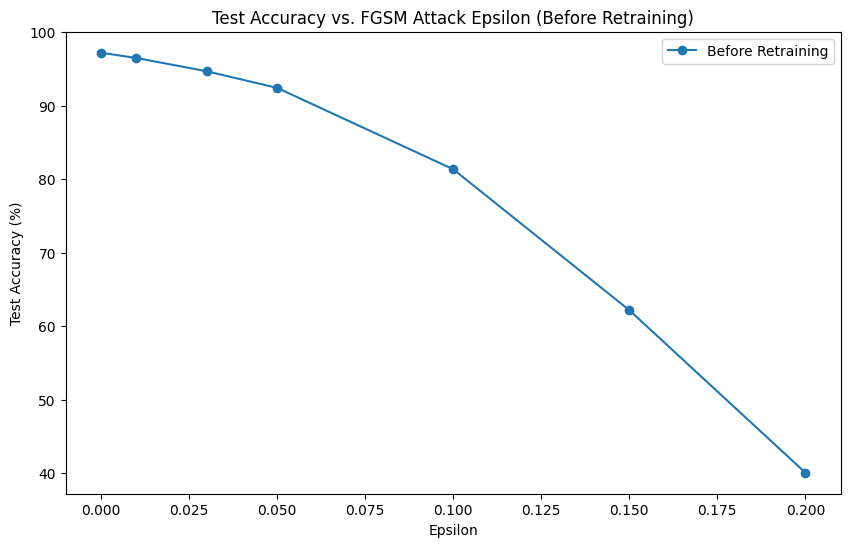

Adversarial Retrain Epoch [1/10], Step [100/235], Loss: 0.1234
Adversarial Retrain Epoch [1/10], Step [200/235], Loss: 0.1055
Adversarial Retrain Epoch [2/10], Step [100/235], Loss: 0.0500
Adversarial Retrain Epoch [2/10], Step [200/235], Loss: 0.0679
Adversarial Retrain Epoch [3/10], Step [100/235], Loss: 0.1088
Adversarial Retrain Epoch [3/10], Step [200/235], Loss: 0.0651
Adversarial Retrain Epoch [4/10], Step [100/235], Loss: 0.0670
Adversarial Retrain Epoch [4/10], Step [200/235], Loss: 0.0883
Adversarial Retrain Epoch [5/10], Step [100/235], Loss: 0.0670
Adversarial Retrain Epoch [5/10], Step [200/235], Loss: 0.0851
Adversarial Retrain Epoch [6/10], Step [100/235], Loss: 0.0631
Adversarial Retrain Epoch [6/10], Step [200/235], Loss: 0.0438
Adversarial Retrain Epoch [7/10], Step [100/235], Loss: 0.0617
Adversarial Retrain Epoch [7/10], Step [200/235], Loss: 0.0381
Adversarial Retrain Epoch [8/10], Step [100/235], Loss: 0.0471
Adversarial Retrain Epoch [8/10], Step [200/235], Loss:

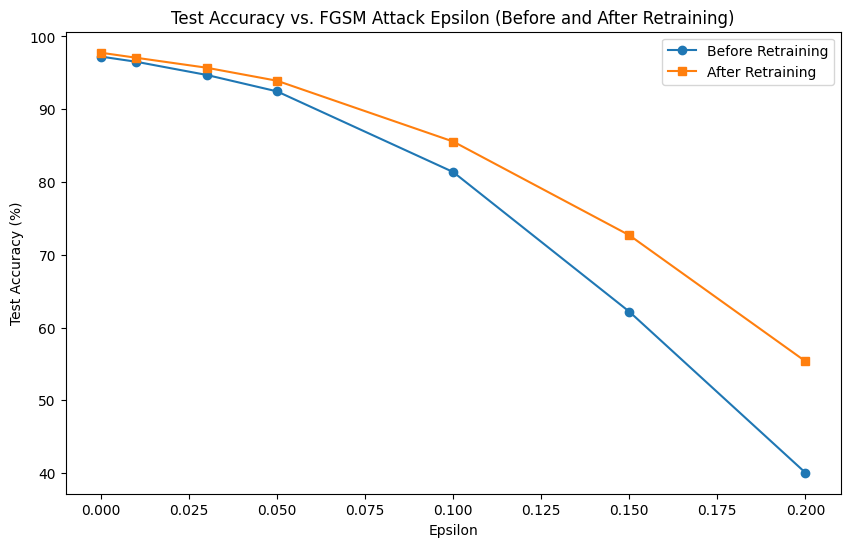

In [5]:
# FGSM Attack and Defend on MLP
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

input_size = 784  
hidden_size = 128
num_classes = 10
num_epochs = 10
batch_size = 256
learning_rate = 0.001
epsilon_values = [0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.fci = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        x = x.view(-1, input_size) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fci(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

def test_model(data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f'Accuracy on the clean test set: {test_model(test_loader):.2f}%')

# FGSM Attack

def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, -1, 1)  
    return perturbed_images

accuracies = []

for epsilon in epsilon_values:
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = 100 * total_correct / total_samples
    accuracies.append(accuracy)
    print(f"Epsilon: {epsilon:.2f}, Test Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o', label='Before Retraining')
plt.title('Test Accuracy vs. FGSM Attack Epsilon (Before Retraining)')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()


# Defend Method

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon=0.03)

        combined_images = torch.cat([images, adv_images], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        outputs = model(combined_images)
        loss = criterion(outputs, combined_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Adversarial Retrain Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print(f'Accuracy on the clean test set after adversarial retraining: {test_model(test_loader):.2f}%')

accuracies_after_retrain = []

for epsilon in epsilon_values:
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = 100 * total_correct / total_samples
    accuracies_after_retrain.append(accuracy)
    print(f"Epsilon: {epsilon:.2f}, Test Accuracy after Retraining: {accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o', label='Before Retraining')
plt.plot(epsilon_values, accuracies_after_retrain, marker='s', label='After Retraining')
plt.title('Test Accuracy vs. FGSM Attack Epsilon (Before and After Retraining)')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()
